# Money transaction in Austrialia - part2
### Prediction of Money transaction by ARIMA and SARIMAX model
Use ARIMA and SARIMAX model to predict future results.
The work here just uses 'date' and 'money amount' data to do prediction, and doing prediction with time period is the advantage of ARIMA model in application.


In [201]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
%matplotlib inline

## 1. Prepare the data

In [202]:
# Read the data
df = pd.read_excel(r'PATH')
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


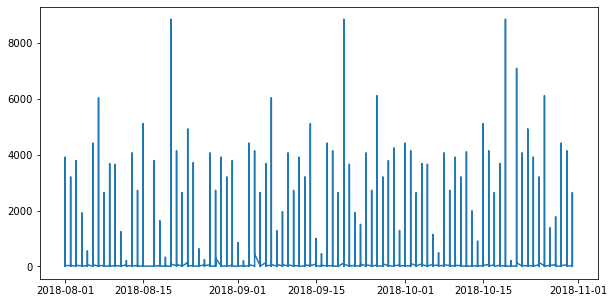

In [203]:
# a quick look on the data change
fig = plt.figure(figsize = (10,5))
plt.plot(df['date'],df['amount'])

In [204]:
# arrange the data into a new dataframe
dateparse = lambda dates: pd.datetime.strtime(dates,'%Y-%m')
predict_1 = pd.DataFrame(df[['date','amount']])
predict_1.head()

,date,amount
0,2018-08-01,16.25
1,2018-08-01,14.19
2,2018-08-01,6.42
3,2018-08-01,40.90
4,2018-08-01,3.25


In [377]:
# sum everyday amount to daily amount, get rid of possible big derivation in days
def daily_amount(data):
    daily_data = data.copy()
    daily_data.date = daily_data.date.apply(lambda x: str(x)[:-4])
    daily_data = daily_data.groupby('date')['amount'].sum().reset_index()
    daily_data.date = pd.to_datetime(daily_data.date)
    return daily_data

In [385]:
# clean the data
daily_df = daily_amount(predict_1)
daily_df = daily_df.dropna()

daily_df.head()

,date,amount
0,2018-08-01,29867.94
1,2018-08-02,21786.32
2,2018-08-03,38096.58
3,2018-08-04,6296.05
4,2018-08-05,4426.50


## 2. Fitting ARIMA model

In [386]:
# check the intervene of money transation in time period
import datetime
def time_plot(data, x, y, topic):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.lineplot(x, y, data=data, ax=ax, color='mediumblue', label='Total Sales')
    ax.set(xlabel = "Date",
            ylabel = "amount",
            title = topic)   


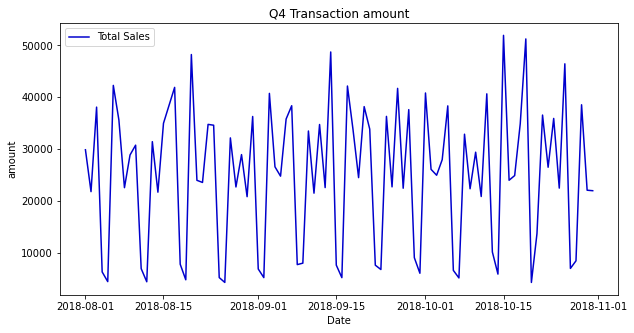

In [387]:
time_plot(daily_df, 'date', 'amount', 'Q4 Transaction amount')

* The data has a seemingly trend occurs in every 1 week (7 days)
* It can be proved by comparing the amounts among each week, if they were close , then there could be a trend

In [388]:
# sum up the amounts for each week
def weekly_amount(data):
    weekly_data = data.copy()
    weekly_data.date = weekly_data.date.apply(lambda x: str(x)[:-4])
    weekly_data.date = pd.to_datetime(weekly_data.date)
    weekly_data = weekly_data.groupby(weekly_data.index//7)['amount'].sum().reset_index()
    return weekly_data

(0.0, 203059.55)

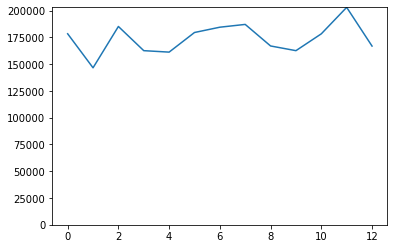

In [389]:
weekly_df = weekly_amount(daily_df)
weekly_df = weekly_df.dropna()

weekly_df.amount.plot()
plt.ylim(0,weekly_df.amount.max())

* Each amount in a 7 days-period is close
* Move forward to calculate if the frequncy of 7 days is in stationary for ARIMA model

In [390]:
# reset the date to index for the amount
daily_df = daily_df.copy().set_index('date')

In [391]:
from statsmodels.tsa.stattools import adfuller
# examine if the data is stationary by the Augmented Dickey Fuller test (adfuller())
# data stationary is based on : mean value, standard deviation (std) and covariance
def test_stationarity(timeseries, window):
    # will set time window = 7 (a week)
    rolmean = timeseries.rolling(window = window).mean()
    rolstd = timeseries.rolling(window = window).std()
    dftest = adfuller(timeseries, autolag = 'AIC') # 
    # the output of dftest is in an order of : test statistic, p value, lags used, observation and critical value of each confidence
    dfoutput = pd.Series(dftest[0:4], index = ['test statistic', 'p value', 'lags used', 'observation used'])
    for key,value in dftest[4].items():
        dfoutput['critical value(%s)' %key] = value
    # plot the rolling statics
    fig = plt.figure(figsize =(10,5))
    fig.add_subplot()
    original = plt.plot(timeseries, label = 'original')
    mean = plt.plot(rolmean, color = 'r', label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label = 'rolling std')
    plt.legend(loc = 'best')
    print('Results of Dickey-Fuller Test:\n', dfoutput)
   

Results of Dickey-Fuller Test:
 test statistic         -3.861381
p value                 0.002338
lags used              12.000000
observation used       78.000000
critical value(1%)     -3.517114
critical value(5%)     -2.899375
critical value(10%)    -2.586955
dtype: float64


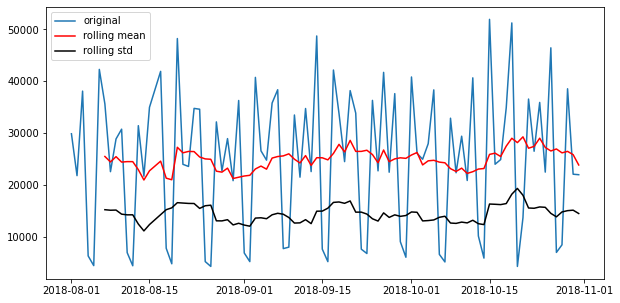

In [392]:
test_stationarity(daily_df,7)
# the p value is 0.002338 less than the significance level (0.05)
# Also, test statistic < critical values means it will reject null hypothesis, the data is stationary

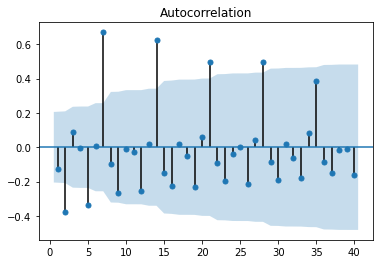

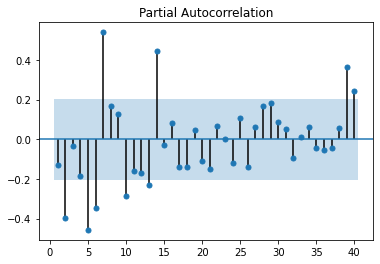

In [393]:
# Since the data is in stationary, then
# find lagged value by ACF (Auto Correlation Function) and PACF (Partial Auto Correlation Function)
# ACF is a linear model, where current period values are a sum of past outcomes multiplied by a numeric factor.
# PACF takes into consideration the correlation between a time series and each of its intermediate lagged values.
# from PACF, get AR from the lags before the first lag goes out of positive significant level
# from ACF, get MA as the same way
import statsmodels.graphics.tsaplots as sgt
acf = sgt.plot_acf(daily_df, zero = False, lags = 40)
pacf = sgt.plot_pacf(daily_df, lags = 40, zero = False,method = ('ols'))

* On looking at ACF and PACF plot, the lag goes into the far negative zone quickly, which indicates the series have been in highly stationary
* On both plots, lag 7 truns out to be insignificant (blue region is significant limit, p < 0.05), so AR < 7 and MA < 7 (7,0,7) are possible values for ARIMA model

In [394]:
# Begin building the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

def model_check(data,AR,I,MA):
    model_ar = ARIMA(data, order = (AR,I,MA)) # note: the higher the Lag, the more calculation required (more running time)
    result_ar = model_ar.fit()
    try:
        print(result_ar.summary())
    except:
        pass

In [559]:
# I = 0 for no differentiation on data
# check which combination of values in range of (7,0,7) could fit the model (least p value and smallest AIC)
model_check(daily_df, 5,0,4) # I found the best combination in (5,0,4)

c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:                 amount   No. Observations:                   91
Model:                     ARMA(5, 4)   Log Likelihood                -948.595
Method:                       css-mle   S.D. of innovations           7662.284
Date:                Sun, 14 Jun 2020   AIC                           1919.190
Time:                        12:14:36   BIC                           1946.810
Sample:                             0   HQIC                          1930.333
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.487e+04    464.263     53.571      0.000     2.4e+04    2.58e+04
ar.L1.amount     0.3256      0.002    166.730      0.000       0.322       0.329
ar.L2.amount    -1.0375      0.007   -144.65

* The model summary reveals the P-Values in 'P>|Z|' column are highly significant because they are all lower than 0.05.
* The next step is to check the residuals to ensure there are no patterns on constant mean and variance.

In [562]:
model = ARIMA(daily_df, order = (5,0,4)) 
results = model.fit()
residuals = results.resid

c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Mean of residuals: 0   -20.079736
dtype: float64


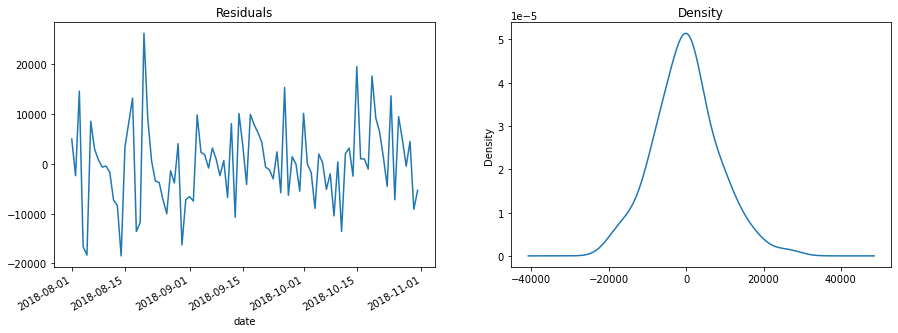

In [563]:
fig,ax = plt.subplots(1, 2, figsize=(15,5))
residuals.plot(title = 'Residuals',ax=ax[0])
residuals.plot(kind = 'kde', title = 'Density',ax=ax[1])
print('Mean of residuals:', pd.DataFrame(residuals).mean())

* The residual's mean seem near zero (which is fine) and residual's variance is uniformed.

c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


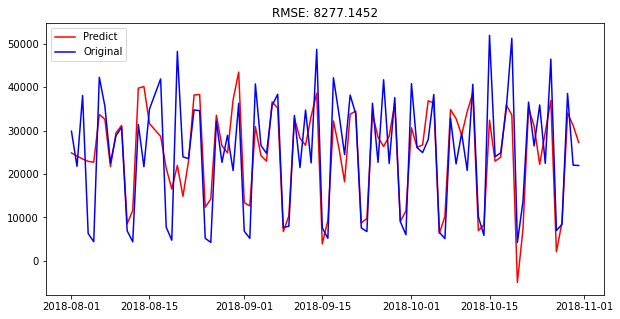

In [596]:
# try plotting3
model_ar = ARIMA(daily_df, order = (5,0,4))
result_ar = model_ar.fit()
predict_ar = result_ar.predict()
  
fig = plt.figure(figsize =(10,5))
fig.add_subplot()
predict = plt.plot(predict_ar, color='red', label='Predict')
origin = plt.plot(daily_df, color='blue', label='Original')
plt.legend(loc='best')
# 
plt.title('RMSE: %.4f'% np.mean((predict_ar-daily_df.amount)**2)**0.5) # Root Mean Squared Error (RMSE)
plt.show()

* This model looks decent
* Need more training and testing to optimize the model

In [513]:
print('data size: ',daily_df.shape)

data size:  (91, 1)


In [677]:
# split the data, train data size is in range of 75%-80% of total data size: 91* 75% = 68,  91* 80% = 72
# give test data to 21 days (3weeks),then train data size = 91-21 = 70
X_train = daily_df[:70]
X_test = daily_df[70:]

c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


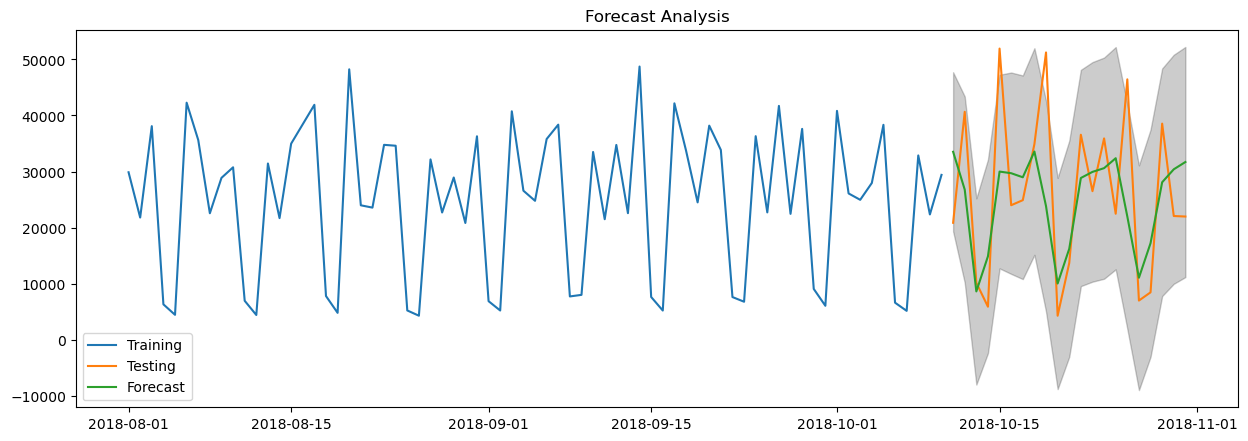

In [678]:
# use the model and plot its figure
test_model = ARIMA(X_train, order = (5,0,4))
fitted = test_model.fit()

fc, se, conf = fitted.forecast(21, alpha = 0.05) # alpha ~ p-value
fc_series = pd.Series(fc, index = X_test.index)
lower_series = pd.Series(conf[:,0], index = X_test.index)
upper_series = pd.Series(conf[:,1], index = X_test.index)

plt.figure(figsize = (15,5), dpi = 100) # Dots per inches (dpi) determines how many pixels the figure comprises
plt. plot(X_train, label = 'Training')
plt. plot(X_test, label = 'Testing')
plt. plot(fc_series, label = 'Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = 0.2)
plt.title('Forecast Analysis')
plt.legend()
plt.show()

* The figure shows that the model has a similar tendancy with actual test values within 95% confidence band.
* The model could be good

### Do accuracy check, usually use the accuracy metrics to judge the fitting:
* Mean Absolute Percentage Error (MAPE)
* Mean Error (ME)
* Mean Absolute Error (MAE)
* Mean Percentage Error (MPE)
* Root Mean Squared Error (RMSE)
* Correlation between Actual and Forecast (Corr)
* Min-Max Erro (MinMax)

In [679]:
def accuracy_metrics(pred, test):
    MAPE = np.mean(np.abs(pred-test)/np.abs(test))
    ME = np.mean(pred-test)
    MAE = np.mean(np.abs(pred-test))
    MPE = np.mean((pred-test)/test)
    RMSE = np.mean((pred-test)**2)**0.5
    mins = np.amin(np.hstack([pred[:,None],test[:,None]]))
    maxs = np.amax(np.hstack([pred[:,None],test[:,None]]))
    MinMax = 1-np.mean(mins/maxs)
    return ({'MAPE':MAPE,'ME':ME,'MAE':MAE,'MPE':MPE,'RMSE':RMSE,'MinMax':MinMax})

In [680]:
accuracy_metrics(pd.DataFrame(fc).values, X_test.values)

{'MAPE': 0.4636799656941805,
 'ME': -1432.0313778033417,
 'MAE': 9434.049179187286,
 'MPE': 0.2116524624476285,
 'RMSE': 11802.845236851077,
 'MinMax': 0.9178791477132276}

* 46% MAPE indicates the model is about 54% accurate in predicting the next 21 observations

## 3. Apply optimized ARIMA model (SARIMAX) that includes seasonal changes

In [400]:
# Analyze the seasonal trends and residuals
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(timeseries, n):
    decomposition = seasonal_decompose(timeseries, freq = n) 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.subplots(figsize =(12,12))
    plt.subplot(411)
    plt.plot(timeseries, label = 'Original')
    plt.legend(loc = 'best')
    plt.subplot(412)
    plt.plot(trend, label = 'Trend')
    plt.legend(loc = 'best')
    plt.subplot(413)
    plt.plot(seasonal, label = 'Seasonal')
    plt.legend(loc = 'best')
    plt.subplot(414)
    plt.plot(residual, label = 'Residual')
    plt.legend(loc = 'best')
    plt.tight_layout()
    
    return trend, seasonal, residual

<ipython-input-400-f77fbc70e8f8>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(timeseries, freq = n)


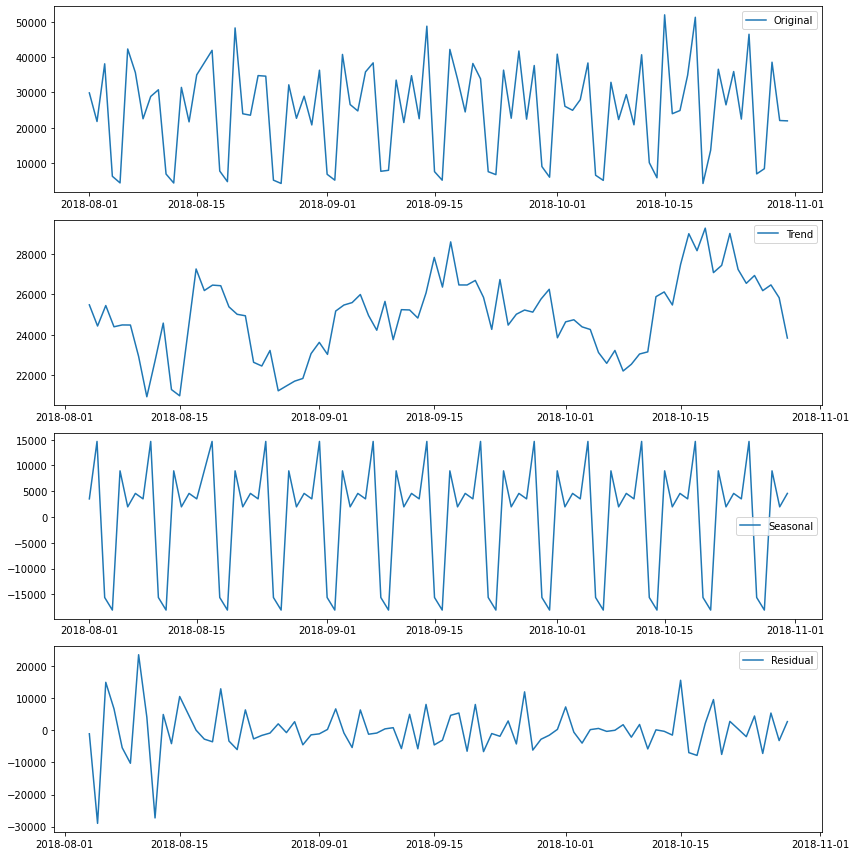

In [401]:
trend, seasonal, residual = decompose(daily_df,7) 
# freq is the periodic frequency of tendancy, 7 is a week
residual.dropna(inplace = True)

Mean of residuals: resid   -146.686608
dtype: float64


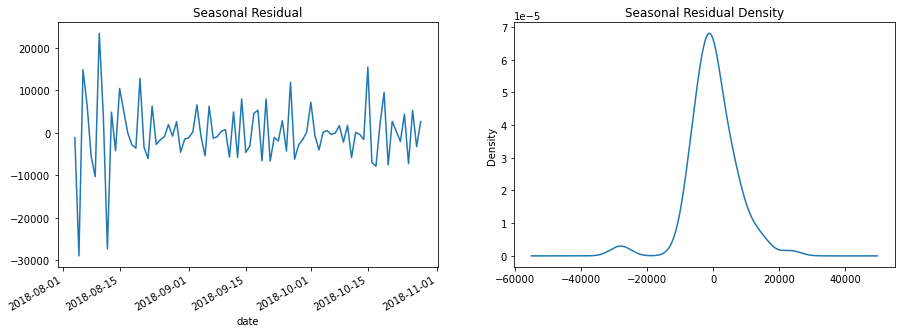

In [407]:
fig,ax = plt.subplots(1, 2, figsize=(15,5))
residual.plot(title = 'Seasonal Residual',ax=ax[0])
residual.plot(kind = 'kde', title = 'Seasonal Residual Density',ax=ax[1])
print('Mean of residuals:', pd.DataFrame(residual).mean())

Results of Dickey-Fuller Test:
 test statistic        -3.763653e+15
p value                0.000000e+00
lags used              9.000000e+00
observation used       8.100000e+01
critical value(1%)    -3.513790e+00
critical value(5%)    -2.897943e+00
critical value(10%)   -2.586191e+00
dtype: float64


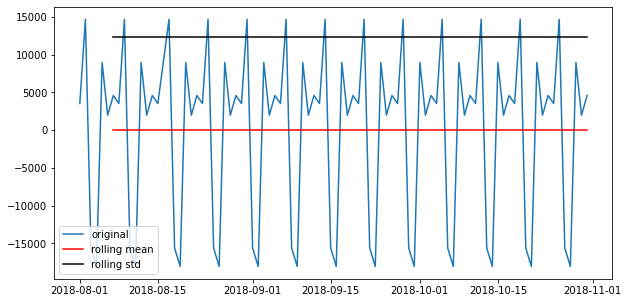

In [408]:
# The seasonal residual 
test_stationarity(seasonal,7)

* The residual's variance is uniformed, and the data contains a seasonal trend
* ARIMA model does not include seasonal changes
* With consideration of seasonal issues, SARIMAX is the better model which involves seasonal parameter in addition to ARIMA

In [567]:
# If use SARIMAX model, finding the AR and MA is also required;
# but auto_arima tool can automatically comput it and the seasonal parameters:
from pmdarima import auto_arima
predict_model_1 = auto_arima(daily_df,
                           max_p = 7, max_q = 7,
                           test = 'adf', # adfuller test
                           seasonal = False,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(predict_model_1.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=1994.982, BIC=2010.047, Time=0.249 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=1993.014, BIC=1998.036, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=1993.501, BIC=2001.034, Time=0.009 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=1988.313, BIC=1995.846, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=2125.822, BIC=2128.333, Time=0.004 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=1994.073, BIC=2004.116, Time=0.035 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=1975.589, BIC=1985.632, Time=0.035 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=1985.656, BIC=1998.210, Time=0.062 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=1976.084, BIC=1988.638, Time=0.043 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=1976.988, BIC=1992.053, Time=0.117 seconds
Total fit time: 0.580 seconds
      

In [568]:
predict_model_1

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

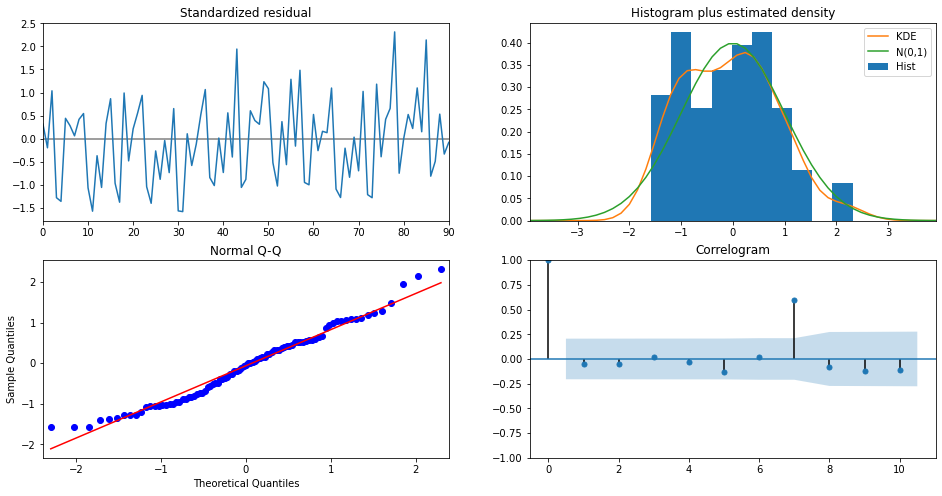

In [569]:
predict_model_1.plot_diagnostics(figsize = (16,8))
plt.show()

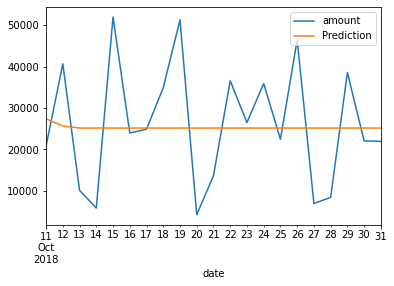

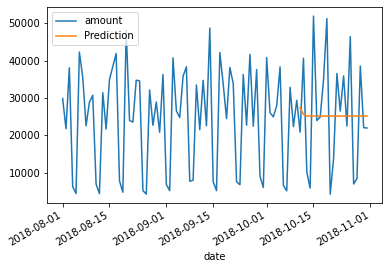

In [570]:
# The new value could be better because it includes the seasonal changes
# try to see how the value fits to the data, a good way is to fit the model into test data
train = daily_df.loc['2018-08-01':'2018-10-11']
test = daily_df.loc['2018-10-11':]
future_forecast = predict_model_1.predict(n_periods = 21) 
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot()
pd.concat([daily_df,future_forecast],axis=1).plot()

* Without seasonl, the auto_arima is unable to find good parameters

In [571]:
# Compare with seasonal
# Find the lowest the AIC value
predict_model_2 = auto_arima(daily_df, 
                           test = 'adf', # adfuller test
                           max_p = 7, max_q = 7, m = 7, # m = 7 is for a week's seasonal period
                           seasonal = True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise = True)
print(predict_model_2.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,7) [intercept=True]; AIC=1961.252, BIC=1981.339, Time=0.559 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=True]; AIC=1993.014, BIC=1998.036, Time=0.005 seconds
Fit ARIMA(1,0,0)x(1,0,0,7) [intercept=True]; AIC=1975.207, BIC=1985.251, Time=0.162 seconds
Fit ARIMA(0,0,1)x(0,0,1,7) [intercept=True]; AIC=1967.802, BIC=1977.845, Time=0.048 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=False]; AIC=2125.822, BIC=2128.333, Time=0.004 seconds
Fit ARIMA(2,0,2)x(0,0,1,7) [intercept=True]; AIC=1956.765, BIC=1974.341, Time=0.420 seconds
Near non-invertible roots for order (2, 0, 2)(0, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(2,0,2)x(1,0,0,7) [intercept=True]; AIC=1970.849, BIC=1988.425, Time=0.404 seconds
Near non-invertible roots for order (2, 0, 2)(1, 0, 0, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.0

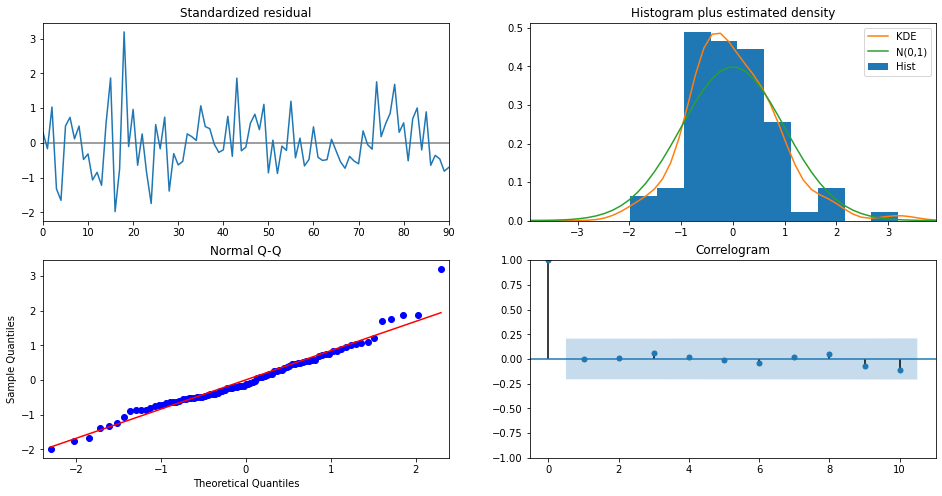

In [530]:
predict_model_2.plot_diagnostics(figsize = (16,8))
plt.show()

###### (6,0,3)x(2,0,0,7) is the best mod for this data suggested by Auto_arima tool
#### the AR and MA are slightly different with ARIMA model

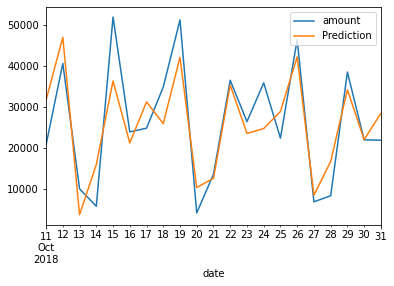

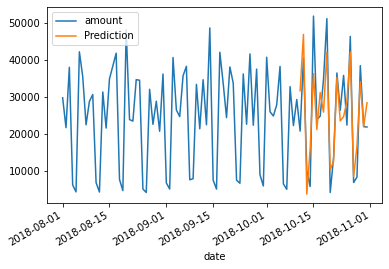

In [668]:
# The new value could be better because it includes the seasonal changes
# try to see how the value fits to the data, a good way is to fit the model into test data
train = daily_df.loc['2018-08-01':'2018-10-11']
test = daily_df.loc['2018-10-11':]
future_forecast = predict_model_2.predict(n_periods = 21) # the test data has 14 days as its frequency
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot()
pd.concat([daily_df,future_forecast],axis=1).plot()

* SARIMAX model with these parameters fits the data very well.

In [501]:
# Use SARIMAX model instead of ARIMA to prove the value selection
# In SARIMAX model (6,0,3)x(2,0,0,7) is the very best
from statsmodels.tsa.statespace.sarimax import SARIMAX
sari_model = SARIMAX(daily_df, order = (6,0,3), seasonal = (2,0,0,7)) 
sari_result = sari_model.fit()
print(sari_result.summary())

c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                 amount   No. Observations:                   91
Model:               SARIMAX(6, 0, 3)   Log Likelihood                -993.343
Date:                Sun, 14 Jun 2020   AIC                           2006.687
Time:                        11:47:03   BIC                           2031.795
Sample:                             0   HQIC                          2016.817
                                 - 91                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5095      0.053      9.597      0.000       0.405       0.614
ar.L2         -0.3257      0.062     -5.219      0.000      -0.448      -0.203
ar.L3          0.1316      0.048      2.721      0.0

c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [502]:
def sarimax_fig(data,p,d,q,P,D,Q,season):
    model = SARIMAX(data, order = (p,d,q),seasonal = (P,D,Q,season))
    results = model.fit()
    fig = plt.figure(figsize =(10,5))
    plt.plot(data)
    plt.plot(results.fittedvalues, color = 'r')
    plt.title('RSS: %.4f'%sum((results.fittedvalues - data.amount)**2))

c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


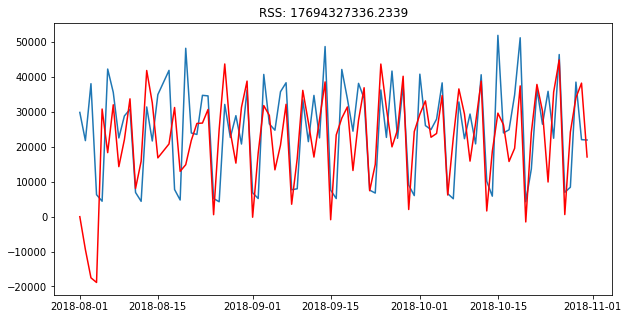

In [503]:
sarimax_fig(daily_df,6,0,3,2,0,0,7)

* The model can fit the data ,  but there are some deviations, getting more data may help to decrease it.

c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packa

NormaltestResult(statistic=12.81892809251486, pvalue=0.001645906395414989)


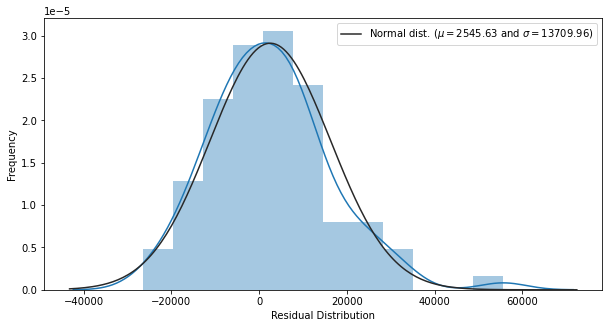

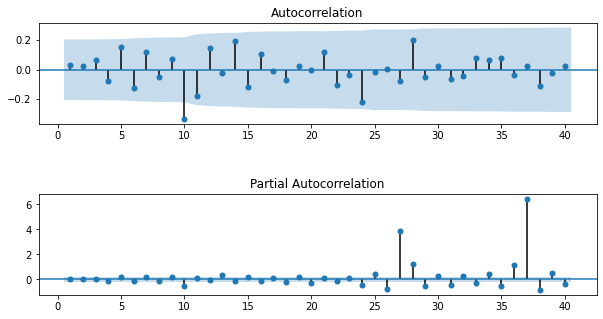

In [458]:
# check the model's confidence
# if the figure close to normal distribution and p value in 95% confidence, this model should be fine
from scipy import stats
from scipy.stats import normaltest

model = SARIMAX(daily_df, order = (6,0,3), seasonal = (2,0,0,7)) 
results_ar = model.fit()
resid = results_ar.resid
print(normaltest(resid))

fig = plt.figure(figsize = (10,5))
ax0 = fig.add_subplot(111)
sns.distplot(resid,fit = stats.norm,ax = ax0)
(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu = ${:.2f} and $\sigma = ${:.2f})'.format(mu,sigma)])
plt.ylabel('Frequency')
plt.xlabel('Residual Distribution')

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(211)
fig = sgt.plot_acf(resid,lags = 40,zero = 0,ax = ax1)
ax2 = fig.add_subplot(212)
fig = sgt.plot_pacf(resid,lags = 40,zero = 0,ax = ax2)
plt.subplots_adjust(wspace= 0.2, hspace = 0.7)
plt.show()

* The p-value is low and within 95% confidence, this model works.

No handles with labels found to put in legend.


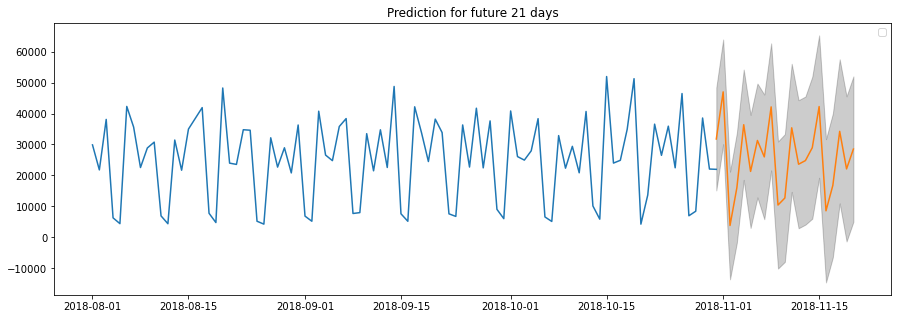

In [594]:
fitval, confi = predict_model_2.predict(n_periods = 21, return_conf_int = True)
fc_index = pd.date_range(daily_df.index[-1],periods = 21)

fitval_series = pd.Series(fitval, index = fc_index)
lower_series = pd.Series(confi[:,0], index = fc_index)
upper_series = pd.Series(confi[:,1], index = fc_index)

plt.figure(figsize = (15,5))
plt.plot(daily_df)
plt.plot(fitval_series)
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = 0.2)
plt.title('Prediction for future 21 days')
plt.legend()
plt.show()

In [681]:
accuracy_metrics(future_forecast.values, test.values)

{'MAPE': 0.3863142870206481,
 'ME': -201.03234871979743,
 'MAE': 6202.568760619335,
 'MPE': 0.1776705962056322,
 'RMSE': 7305.589816988904,
 'MinMax': 0.9262667957943476}

* The Accuracy of SARIMAX is 1-0.38 = 62% accurate, abit better than ARIMAX (54%)

### Comments: 
* this project have built a nice model for money transaction data, but the dataset only contains 3 months data, it needs to be verified under much lagger data scale to get more accurate prediction
* SARIMAX have seasonal matrix in addition to ARIMA, if there is a seasonal change, SARIMAX is better than ARIMA.
* There are a lot more statistic evaluation on these models, such as White Noise and Intervals, many are complicated, I may try to include them in the future works.